<a href="https://colab.research.google.com/github/nosovdmitry007/CV_Filtr_foto/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ФИЛЬТР УДАЧНЫХ ФОТОГРАФИЙ

  Необходимо отсортировать фотографии, т.е. класифицировать изображения по качеству (удачные фотографии).


Будем расмаирмваить фотографии в формате RAW

Для начала определимся по каким критериям будем сортировать фотографии.

1. фотография пересвечена 30 шт.
2. фотография очень темная 30 шт.
3. фотография смазана 30 шт.
4. фотография без фокуса 30 шт.
5. Сильные шумы (делаем програмно 30 шт.)
6. Искажение геометрии 30 шт. 
7. полосы от ламп, Мерцание 30 шт.
8. Удачные фотографии 60 шт.

https://drive.google.com/drive/folders/1ktqIOC_O9tj7Z3wJ4E6xYaPc9epmBWC0?usp=sharing

Все фотографии после загрузки будем поворачивать для получения более полной базы.
в итоге получится база из 97200 элементов (фотографий)

In [ ]:
!pip install rawpy;

In [ ]:
import rawpy #открытие RAW фотографий
import imageio #открытие RAW фотографий
import numpy as np
from PIL import Image
from tqdm import tqdm #Индикатор Прогресса
from tensorflow.keras.preprocessing import image
import os #Работа с папками и файлами
import cv2 #OpenCV — это open source библиотека компьютерного зрения, которая предназначена для анализа, классификации и обработки изображений
from tensorflow.keras import utils #Утилиты для to_categorical
from matplotlib import pyplot as plt
import random #Для генерации случайных чисел
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization #Слои НС
from tensorflow.keras.models import Sequential #Сеть прямого распространения
import keras
import time
import datetime
import sys

#Парсинг данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Создаём модуль для добавления шума
def noisy(noise_typ,image):
   if noise_typ == 'gauss':
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == 's&p':
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out

In [ ]:

#Создаём классы по которым будем класифицировать фотографии
className=['Fokus','Geometriy','Horoshie_foto','Miganie','Peresvet','shum','Smazany','Temniy']

In [ ]:
#Размер изображения для НС
visota=50
shirina=50
sloi=3

In [ ]:
x_test = [] 
y_test =[]
x_train =[] 
y_train =[] 

#будем делить вю выборку на обучающую и тестовую в соотношении 90% к 10%
#также сразу будет поворачивать фотографии и добавлять шума в класс шум
#решепим фотографии до размера 50*59, иначе не хватает ОЗУ
clas=-1
for i in className: #Проходим по каждому классу
  print(i)
  Fil=len(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)) )
  T=0
  clas+=1
  #цыкл по каждой фотографии в классе
  for j in tqdm(os.listdir('/content/drive/MyDrive/Диплом/'+str(i)),colour = 'green',ncols =100):
      T+=1
      #преобразуем RAW фотографию в Jepg
      with rawpy.imread('/content/drive/MyDrive/Диплом/'+str(i)+'/' + j) as raw:
          thumb = raw.extract_thumb()
      if thumb.format == rawpy.ThumbFormat.JPEG:
        with open('thumb.jpeg', 'wb') as f:
          f.write(thumb.data)
      elif thumb.format == rawpy.ThumbFormat.BITMAP:
        imageio.imsave('thumb.jpeg', thumb.data)  #сохраняем фото в формате jpeg
        
      L=Image.open('thumb.jpeg') #Открываем фото jpeg
      z = L.resize((visota, shirina)) #Изменяем размер фотографии
      #Распределяем выборку фотграфий на обучающую и тестовую 
      if T<=Fil*0.9:
        for k in range(360): #поворачиваем картинку на 360 градусов по 1 градусу
          o =z.rotate(k)
          x = image.img_to_array(o)
          x=x.reshape(visota, shirina,sloi) 
         
          x /= 255 #нормируем фотографию

          x_train.append(x) #добавляем в обучающую выборку
          y_train.append(clas) #записываем класс фотографии
      else:
        for k in range(360):
          o =z.rotate(k)
          x = image.img_to_array(o)
          x=x.reshape(visota, shirina,sloi) 
          
          x /= 255 #нормируем фотографию
         
          x_test.append(x) #добавляем в тестовую выборку
          y_test.append(clas) #записываем класс фотографии
  print()

Fokus


100%|███████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.79it/s]



Geometriy


100%|███████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.61it/s]



Horoshie_foto


100%|███████████████████████████████████████████████████████████████| 60/60 [00:30<00:00,  1.96it/s]



Miganie


100%|███████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.09it/s]



Peresvet


100%|███████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]



shum


100%|███████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]



Smazany


100%|███████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.57it/s]



Temniy


100%|███████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.47it/s]

In [ ]:
#Преобразуем в нампай массив
x_test = np.array(x_test)  
y_test =np.array(y_test) 
x_train =np.array(x_train) 
y_train =np.array(y_train) 

In [ ]:
x_train.shape

(87480, 50, 50, 3)

In [ ]:
x_test.shape

(9720, 50, 50, 3)

In [ ]:
y_train

array([0, 0, 0, ..., 7, 7, 7])

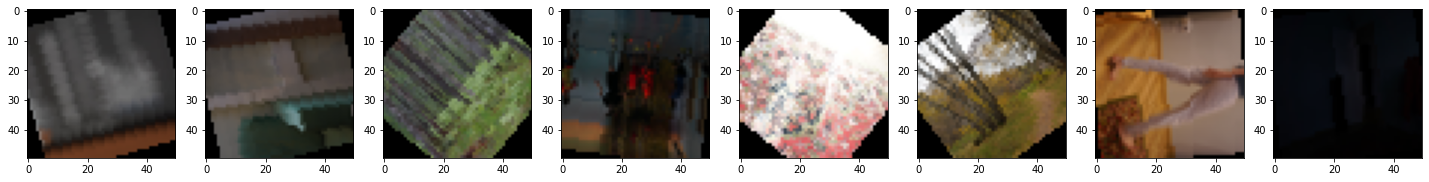

In [ ]:
#Выводим для примера картинки по каждому классу
 
fig, axs = plt.subplots(1, 8, figsize=(25, 3)) #Создаем полотно из 8 графиков
z=-1
for i in range(8): #Проходим по классам от 0 до 7
  z+=1
  label_indexes = np.where(y_train==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_train[index] #Выбираем из x_train нужное изображение
  axs[i].imshow(Image.fromarray((img * 255).astype(np.uint8))) #Отображаем изображение i-ым графиков
 
plt.show() #Показываем изображения

In [ ]:
 #Преобразует вектор класса (целые числа) в бинарную матрицу класса
y_train = utils.to_categorical(y_train, 8)
y_test = utils.to_categorical(y_test, 8)

In [ ]:
#Выводим размкрности всех выборок для обучения НС
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(87480, 50, 50, 3)
(87480, 8)
(9720, 50, 50, 3)
(9720, 8)


#Нейросеть

In [ ]:
#задаём batch_size
batch_size = 128
 
#Создаем последовательную модель
model = Sequential()
#Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(visota, shirina,sloi)))
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой пакетной нормализации
model.add(BatchNormalization())
#Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой пакетной нормализации
model.add(BatchNormalization())
#Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
 
#Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Выходной полносвязный слой
model.add(Dense(8, activation='softmax'))

In [ ]:
#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
 

In [ ]:
#архитектурв НС
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 50, 50, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 32)      

Epoch 1/20
684/684 [==============================] - 47s 67ms/step - loss: 0.2476 - accuracy: 0.9108 - val_loss: 0.1320 - val_accuracy: 0.9549
Epoch 2/20
684/684 [==============================] - 46s 67ms/step - loss: 0.0523 - accuracy: 0.9840 - val_loss: 0.2708 - val_accuracy: 0.9091
Epoch 3/20
684/684 [==============================] - 45s 66ms/step - loss: 0.0310 - accuracy: 0.9910 - val_loss: 0.5737 - val_accuracy: 0.8850
Epoch 4/20
684/684 [==============================] - 46s 67ms/step - loss: 0.0274 - accuracy: 0.9931 - val_loss: 0.8312 - val_accuracy: 0.8927
Epoch 5/20
684/684 [==============================] - 45s 66ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.3340 - val_accuracy: 0.9246
Epoch 6/20
684/684 [==============================] - 46s 67ms/step - loss: 0.0226 - accuracy: 0.9940 - val_loss: 0.4481 - val_accuracy: 0.9120
Epoch 7/20
684/684 [==============================] - 47s 68ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.8551 - val_accuracy:

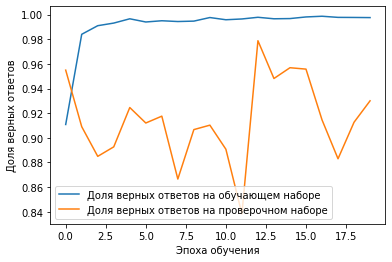

In [ ]:
#Обучаем сеть
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_test, y_test),
                    verbose=1)
 
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Вывод

Точность нейросети очень хорошая достигает 99,9% на 6 эпохе.


В дальнейшем планирую написать колбек для сохранения модели с наилучшим результатом и протестировать ее на фотографиях которых не было в выборке.

#Пишем свой Callback, для сохранения модели.

In [ ]:
 
 
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Прекратите тренироваться, когда убыток достигнет своего минимума, т. е. убыток перестанет уменьшаться.
 
  Аргументы:
      терпение: Количество эпох, которые нужно подождать после того, как будет пройдена минута. После этого
      количество улучшений отсутствует, тренировки прекращаются.
  """
 
    def __init__(self, patience=5):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights для хранения весов, при которых происходит минимальная потеря.
 
 
    def on_train_begin(self, logs=None):
        # Количество эпох, которое он ждал, когда потери больше не будут минимальными.
        self.wait = 0
        # Эпоха, на которой заканчивается обучение.
        self.stopped_epoch = 0
        # Инициализируйте лучшее как бесконечность.
        self.best = np.Inf
 
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Запишите лучшие веса, если текущие результаты лучше (меньше).
            self.best_weights = self.model.get_weights()
            #сохраняем модель
 
            model.save('best_model_'+str(round(logs.get('val_accuracy')*100,2))+'.h5')
            print('  Сохранена модель  на эпохе: ' ,epoch, 'с точностью: ', str(round(logs.get('val_accuracy')*100,2)),'%')
        else:
          self.wait += 1
          if self.wait >= self.patience:
              self.stopped_epoch = epoch
              self.model.stop_training = False
              print("Восстановление весов моделей с конца лучшей эпохи.")
              self.model.set_weights(self.best_weights)

необходимо достичь точность 99,97-99,99%

In [ ]:
#Обучаем сеть
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=50,
                    validation_data=(x_test, y_test),
                    verbose=1,callbacks=[EarlyStoppingAtMinLoss()])
 
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/50
684/684 [==============================] - 46s 67ms/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 1.3630 - val_accuracy: 0.8976
Epoch 2/50
684/684 [==============================] - 46s 68ms/step - loss: 0.0083 - accuracy: 0.9982 - val_loss: 0.1709 - val_accuracy: 0.9612
Epoch 3/50
684/684 [==============================] - 46s 67ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 3.4253 - val_accuracy: 0.6787
Epoch 4/50
684/684 [==============================] - 46s 67ms/step - loss: 0.0158 - accuracy: 0.9971 - val_loss: 0.1607 - val_accuracy: 0.9689
Epoch 5/50
684/684 [==============================] - 46s 67ms/step - loss: 0.0228 - accuracy: 0.9968 - val_loss: 0.0759 - val_accuracy: 0.9763
Epoch 6/50
684/684 [==============================] - 46s 67ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.2303 - val_accuracy: 0.9531
Epoch 7/50
239/684 [=========>....................] - ETA: 28s - loss: 0.0058 - accuracy: 0.9989

# Проверяем точность модели

In [ ]:
xTest = [] 
yTest =[]

#будем делить вю выборку на обучающую и тестовую в соотношении 90% к 10%
#также сразу будет поворачивать фотографии и добавлять шума в класс шум
#решепим фотографии до размера 50*59, иначе не хватает ОЗУ
clas=-1
for i in className: #Проходим по каждому классу
  print(i)
  Fil=len(os.listdir('/content/drive/MyDrive/Диплом/TEST/'+str(i)) )
  T=0
  clas+=1
  for j in tqdm(os.listdir('/content/drive/MyDrive/Диплом/TEST/'+str(i)),colour = 'green',ncols =100):
      T+=1
      with rawpy.imread('/content/drive/MyDrive/Диплом/TEST/'+str(i)+'/' + j) as raw:
          #rgb = raw.postprocess()
          thumb = raw.extract_thumb()
      if thumb.format == rawpy.ThumbFormat.JPEG:
        with open('thumb.jpeg', 'wb') as f:
          f.write(thumb.data)
      elif thumb.format == rawpy.ThumbFormat.BITMAP:
        imageio.imsave('thumb.jpeg', thumb.data)
        
      L=Image.open('thumb.jpeg')
      z = L.resize((visota, shirina))
      x = image.img_to_array(z)
      x=x.reshape(visota, shirina,sloi) 
      
      x /= 255
      
      xTest.append(x) #добавляем в обучающую выборку
      yTest.append(clas)
      
  print()

Fokus


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]



Geometriy


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]



Horoshie_foto


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]



Miganie


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]



Peresvet


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]



shum


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]



Smazany


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]



Temniy


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]

In [ ]:
#Преобразуем в нампай массив
xTest = np.array(xTest)  
yTest =np.array(yTest) 


In [ ]:
xTest.shape

(8, 50, 50, 3)

In [ ]:
yTest.shape

(8,)

In [ ]:
yTest

array([0, 1, 2, 3, 4, 5, 6, 7])

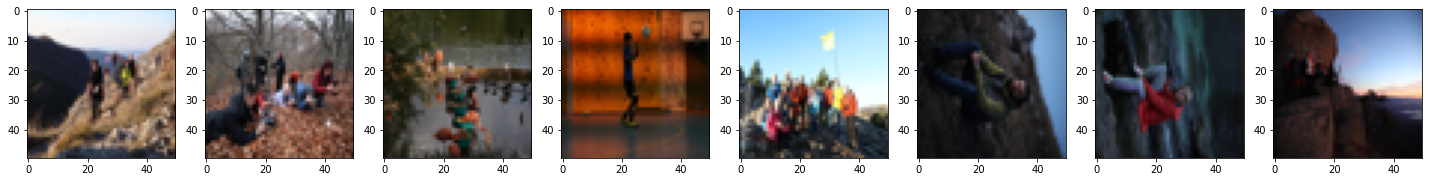

In [ ]:
#Выводим для примера картинки по каждому классу
 
fig, axs = plt.subplots(1, 8, figsize=(25, 3)) #Создаем полотно из 8 графиков
z=-1
for i in range(8): #Проходим по классам от 0 до 7
  z+=1
  label_indexes = np.where(yTest==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = xTest[index] #Выбираем из x_train нужное изображение
  axs[i].imshow(Image.fromarray((img * 255).astype(np.uint8))) #Отображаем изображение i-ым графиков
 
plt.show() #Показываем изображения

In [ ]:
yTest = utils.to_categorical(yTest, 8) 


In [ ]:
#Выводим размкрности всех выборок для обучения НС
print(xTest.shape)
print(yTest.shape)


(8, 50, 50, 3)
(8, 8)


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('best_model_100.0.h5', compile = False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 50, 50, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       1

In [ ]:
prediction = model1.predict(xTest) #Классифицируем каждое изображение
for i in range(8): #Проходим по картинкам
  #Вводим результаты на экран
  print("Распознанный образ:", className[np.argmax(prediction[i])], '. Верный ответ', className[i])

Распознанный образ: Horoshie_foto . Верный ответ Fokus
Распознанный образ: Fokus . Верный ответ Geometriy
Распознанный образ: Horoshie_foto . Верный ответ Horoshie_foto
Распознанный образ: Fokus . Верный ответ Miganie
Распознанный образ: Horoshie_foto . Верный ответ Peresvet
Распознанный образ: Horoshie_foto . Верный ответ shum
Распознанный образ: Miganie . Верный ответ Smazany
Распознанный образ: Horoshie_foto . Верный ответ Temniy
